In [1]:
import numpy as np

In [2]:
from scipy.sparse import csr_matrix as csr
from scipy.sparse import diags
from scipy.sparse import linalg

In [3]:
import matplotlib.pyplot as plt

# Grid Geometry

In [4]:
grid_num = 200

In [5]:
grid_xedge = 1000./grid_num
grid_yedge = 200
grid_zedge = 10

In [6]:
grid_xarea = grid_yedge*grid_zedge

# Rock Properties

In [7]:
rock_poro = 0.2
rock_xperm = 100
rock_comp = 0

# Black Oil System

In [8]:
oil_visc = 1
oil_comp = 0
oil_fvf = 1

In [9]:
wat_visc = 1
wat_comp = 0
wat_fvf = 1

In [10]:
def krw(Sw):
  return 0.3*((Sw-0.2)/(1-0.2-0.4))**2

In [11]:
def kro(Sw):
  return 0.8*((1.0-Sw-0.4)/(1-0.2-0.4))**2

# Well Input

In [12]:
w1_block = (0,)
w1_radius = 0.25
w1_wrate = 1000
w1_skin = 0

In [13]:
w2_block = (grid_num-1,)
w2_radius = 0.25
w2_rate = -1000
w2_skin = 0

# Time Settings

In [14]:
deltat = 0.1

# Reservoir Initialization

In [15]:
init_press = 1000 # not used in the calculations
init_swater = 0.2 # not used in the calculations

In [16]:
Pn = np.zeros((grid_num,))+init_press

In [17]:
Swn = np.zeros((grid_num,))+init_swater

# Transmissibility Calculations

In [18]:
xrock = (rock_xperm*grid_xarea)/grid_xedge*6.33e-3

In [19]:
def upwinding(Mo,Mw,Pn,grid_num):

    Mo_upwinded = np.zeros((grid_num-1,))
    Mw_upwinded = np.zeros((grid_num-1,))
    
    for index in range(grid_num-1):
        if Pn[index]>Pn[index+1]:
            Mo_upwinded[index] = Mo[index]
            Mw_upwinded[index] = Mw[index]
        else:
            Mo_upwinded[index] = Mo[index+1]
            Mw_upwinded[index] = Mw[index+1]

    return Mo_upwinded,Mw_upwinded

# Storage and Total Compressibility Calculations

In [20]:
accum = grid_xarea*grid_xedge*rock_poro/deltat

In [21]:
def get_ct(cr,co,cw,Sw):
  return cr+Sw*cw+(1-Sw)*co

# Well B.C. Calculations

In [22]:
def equivalent_radius(perm1,perm2,edge1,edge2):
    """Returns equivalent radius of grids that contains well."""
    sqrt21 = np.power(perm2/perm1,1/2)*np.power(edge1,2)
    sqrt12 = np.power(perm1/perm2,1/2)*np.power(edge2,2)

    quar21 = np.power(perm2/perm1,1/4)
    quar12 = np.power(perm1/perm2,1/4)

    return 0.28*np.sqrt(sqrt21+sqrt12)/(quar21+quar12)

In [23]:
req = equivalent_radius(rock_xperm,rock_xperm,grid_xedge,grid_yedge)

In [24]:
w1_PI = (2*np.pi*grid_zedge*rock_xperm)/(np.log(req/w1_radius)+w1_skin)*6.33e-3
w2_PI = (2*np.pi*grid_zedge*rock_xperm)/(np.log(req/w2_radius)+w2_skin)*6.33e-3

# Matrix Construction

In [25]:
def matrix(grid_num,wtrans,otrans,Mw,Mo):
    
    index = np.arange(grid_num)

    Tw = csr((grid_num,grid_num))

    Tw += csr((wtrans,(index[:-1],index[:-1])),shape=(grid_num,grid_num))
    Tw -= csr((wtrans,(index[:-1],index[1:] )),shape=(grid_num,grid_num))
    
    Tw += csr((wtrans,(index[1:], index[1:] )),shape=(grid_num,grid_num))
    Tw -= csr((wtrans,(index[1:], index[:-1])),shape=(grid_num,grid_num))

    To = csr((grid_num,grid_num))
    
    To += csr((otrans,(index[:-1],index[:-1])),shape=(grid_num,grid_num))
    To -= csr((otrans,(index[:-1],index[1:] )),shape=(grid_num,grid_num))
    
    To += csr((otrans,(index[1:], index[1:] )),shape=(grid_num,grid_num))
    To -= csr((otrans,(index[1:], index[:-1])),shape=(grid_num,grid_num))

    Qw = csr((grid_num,1))
    Qo = csr((grid_num,1))

    Qw[0,0] = w1_wrate
    Qo[0,0] = 0

    Qw[grid_num-1,0] = w2_rate*Mw[grid_num-1]/(Mw[grid_num-1]+Mo[grid_num-1])
    Qo[grid_num-1,0] = w2_rate*Mo[grid_num-1]/(Mw[grid_num-1]+Mo[grid_num-1])

    return Tw,To,Qw,Qo

# Time Loop

In [26]:
A = diags(np.zeros((grid_num,))+accum)

for k in range(1000):
    
    Mo = kro(Swn)/(oil_visc*oil_fvf)
    Mw = krw(Swn)/(wat_visc*wat_fvf)
    
    Mou,Mwu = upwinding(Mo,Mw,Pn,grid_num)

    otrans = Mou*xrock
    wtrans = Mwu*xrock

    w1_PI_o = w1_PI*Mo[w1_block]
    w1_PI_w = w1_PI*Mw[w1_block]

    w2_PI_o = w2_PI*Mo[w2_block]
    w2_PI_w = w2_PI*Mw[w2_block]

    Tw,To,Qw,Qo = matrix(grid_num,wtrans,otrans,Mw,Mo)

    T = Tw+To+diags(np.ones((grid_num,))*1e-10)
    Q = Qw+Qo

    Pn = linalg.spsolve(T,Q)
    
    Swn = Swn+linalg.spsolve(A,-Tw.dot(csr(Pn.reshape((-1,1))))+Qw)
    

C:\Users\3876yl\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\3876yl\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


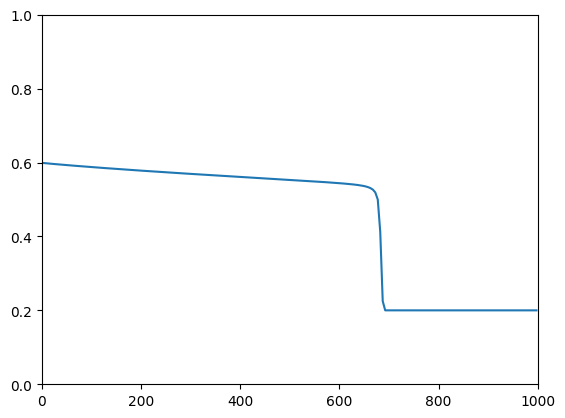

In [27]:
grid_xcenter = np.arange(grid_xedge/2,1000+grid_xedge/2,grid_xedge)

plt.plot(grid_xcenter,Swn)
plt.xlim((0,1000))
plt.ylim((0,1.))
plt.show()